# Convolutional Neural Network - Gap / Char Classification
Using TensorFlow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib notebook

# Creating CSV
import glob
import csv

# Helpers
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.12.1
TensorFlow: 1.0.1


In [2]:
def sofmaxLabels(lab):
    """ Transform labels for sofmax classification """
    newLab = np.zeros((len(lab), 2), dtype=np.int8)
    for i in range(len(lab)):
        newLab[i][int(lab[i][0])] = 1
    return newLab

## Load Images and Lables in CSV

In [3]:
# dimension 30x60 = 1800
images = np.genfromtxt('data/gapdet/data.csv', delimiter=',')
labels = np.genfromtxt('data/gapdet/labels.csv', delimiter=',')
labels = np.reshape(labels, (len(labels), 1))

# Additional regularization of image data
images[images < 40] = 0
images = images.astype(np.float32)
images = np.multiply(images, 1.0 / 255.0)

print("CSV data files loaded.")
print("Number of images: " + str(len(images)))

# Splitting on train and test data
div = int(0.90 * len(images))

llabels = sofmaxLabels(labels)

trainData = images[0:div]
trainLabels = llabels[0:div]

evalData = images[div:]
evalLabels = llabels[div:]

print("Training images: %g" % div)

CSV data files loaded.
Number of images: 22234
Training images: 20010


# Create classifier

### Dataset

In [4]:
# Prepare training dataset
trainSet = DataSet(trainData, trainLabels)

## Convulation Neural Network

### Graph

In [5]:
sess = tf.InteractiveSession()

# Help functions for standard layers
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# Place holders for data (x) and labels (y_)
x = tf.placeholder(tf.float32, [None, 1800], name="x")
y_ = tf.placeholder(tf.float32, [None, 2])

# Reshape input data
x_image = tf.reshape(x, [-1, 30, 60, 1])

# 1. Layer - Convulation + Subsampling
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 20], stddev=0.1), name="W_conv1")
b_conv1 = tf.Variable(tf.constant(0.1, shape=[20]), name="b_conv1")

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# 2. Layer - Max Pool
h_pool1 = max_pool_2x2(h_conv1)

# 3. Layer - Convulation + Subsampling
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 20, 50], stddev=0.1), name="W_conv2")
b_conv2 = tf.Variable(tf.constant(0.1, shape=[50]), name="b_conv2")

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 4. Layer - Max Pool
h_pool2 = max_pool_2x2(h_conv2)

# 5. Fully Connected layer
W_fc1 = tf.Variable(tf.truncated_normal([8*15*50, 500], stddev=0.1), name="W_fc1")
b_fc1 = tf.Variable(tf.constant(0.1, shape=[500]), name="b_fc1")

h_conv2_flat = tf.reshape(h_pool2, [-1, 8*15*50])
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

# 6. Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 7. Output layer
W_fc2 = tf.Variable(tf.truncated_normal([500, 2], stddev=0.1), name="W_fc2")
b_fc2 = tf.Variable(tf.constant(0.1, shape=[2]), name="b_fc2")

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


# Activation function for real use in application
activation = tf.argmax(tf.matmul(h_fc1, W_fc2) + b_fc2, 1)
tf.add_to_collection("activation", activation)


# Cost: cross entropy + regularization
# Regularization with L2 Regularization with decaying learning rate 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)

beta = 0.001
regularizers = tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(W_fc1)
cost = tf.reduce_mean(cross_entropy + beta * regularizers)


# Optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)


# Evaluating
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training

<IPython.core.display.Javascript object>


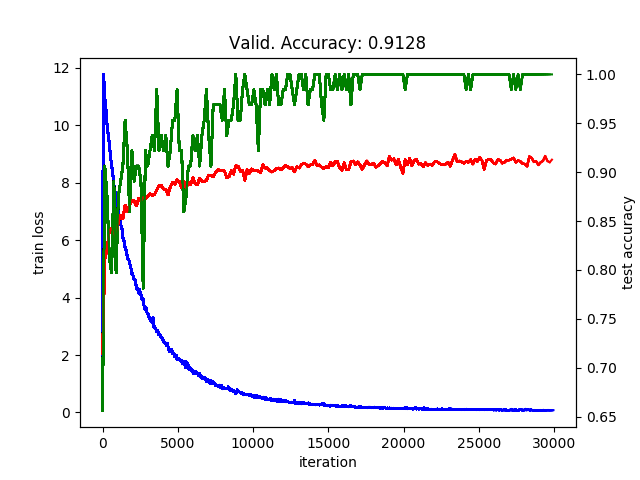

Accuracy 0.914568


In [6]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### SETTINGS  ###
TRAIN_STEPS = 30000
TEST_ITER = 150
COST_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64

# Graph for live ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, COST_ITER)

for i in range(TRAIN_STEPS):
    trainBatch, labelBatch = trainSet.next_batch(BATCH_SIZE)
    
    if i%COST_ITER == 0:
        # Plotting cost
        tmpCost = cost.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
        trainPlot.updateCost(tmpCost, i // COST_ITER)
    
    if i%TEST_ITER == 0:
        # Plotting accuracy
        accEval = accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0})
        accTrain = accuracy.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
        trainPlot.updateAcc(accEval, accTrain, i // TEST_ITER)
        
    if i%SAVE_ITER == 0:
        # Saving model
        saver.save(sess, 'models/gap-clas/CNN-CG')

    train_step.run(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 0.4})

saver.save(sess, 'models/gap-clas/CNN-CG')

print("Accuracy %g" % accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0}))

sess.close()